In [1]:
import pandas as pd
import numpy as np

In [3]:
word = pd.read_csv("data/word.csv")

In [4]:
#读取正面情感词表
with open("../code01/data/Pos_mo_Chinese.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()
pos_emotion = pd.DataFrame(lines)[0].str.rstrip("\n")

In [5]:
#读入正面评价词表
with open("../code01/data/Pos_comm_Chinese.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()
pos_comment=pd.DataFrame(lines)[0].str.rstrip("\n")

In [6]:
#读入负面情感词表
with open("../code01/data/Neg_mo_Chinese.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()
neg_emotion = pd.DataFrame(lines)[0].str.rstrip("\n")

In [7]:
#读入负面评价此表
with open("../code01/data/Neg_comm_Chinese.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()
neg_comment = pd.DataFrame(lines)[0].str.rstrip("\n")

In [8]:
# 合并情感词与评价词
positive = set(pos_comment) | set(pos_emotion)
print(positive)
negative = set(neg_comment) | set(neg_emotion)
intersection = positive & negative  # 正负面情感词表中相同的词语

{'', '热点 ', '百读不厌 ', '好用 ', '凝神 ', '润 ', '昭然若揭 ', '姝 ', '卓著 ', '扰攘 ', '称道 ', '日有所思 ', '忠鲠 ', '人寿年丰 ', '交口称誉 ', '省事 ', '红得发紫 ', '清真 ', '疯魔 ', '博学多闻 ', '典型 ', '海枯石烂 ', '厮熟 ', '忘乎所以 ', '温馨 ', '热情 ', '照样 ', '活跃 ', '坚 ', '傲然 ', '流利 ', '朴实无华 ', '灵验 ', '耐久 ', '芊 ', '言之有理 ', '秀异 ', '狂热 ', '睿智 ', '敦实 ', '完善 ', '史无前例 ', '万夫不当 ', '灵透 ', '学富五车 ', '客观上 ', '勐 ', '朴素 ', '露骨 ', '高超 ', '严正 ', '精力充沛 ', '流芳千古 ', '引人深思 ', '高雅 ', '想 ', '快人快语 ', '犒劳 ', '老实 ', '精精神神 ', '粗实 ', '千方百计 ', '不容置疑 ', '理想 ', '赏心悦目 ', '有血气 ', '斯斯文文 ', '顾惜 ', '雅观 ', '性情温良 ', '缜 ', '叩头 ', '嘴稳 ', '晃眼 ', '目光灼灼 ', '保皇 ', '忌 ', '驯 ', '万夫莫当 ', '有见地 ', '壮烈 ', '挑三拣四 ', '熙熙攘攘 ', '当之无愧 ', '冀 ', '详密 ', '熟识 ', '威风凛凛 ', '诚心诚意 ', '批准 ', '灿然 ', '阳刚 ', '狷 ', '准确无误 ', '不错 ', '地道 ', '言必有中 ', '最高级 ', '偏 ', '后生可畏 ', '利嘴 ', '质量好 ', '合口 ', '性命攸关 ', '光可鉴人 ', '泠泠 ', '居高临下 ', '亘古未有 ', '吐口 ', '兵强马壮 ', '丰 ', '简短 ', '节俭 ', '欣然 ', '博古通今 ', '宽宏大量 ', '杰出 ', '极热心 ', '文质彬彬 ', '不愧 ', '脉脉 ', '强有力 ', '始终不懈 ', '全 ', '甜美 ', '使用方便 ', '小康 ', '泼悍 ', '明晃晃 ', '妒恨 ', '直来直去 ', '

In [9]:
positive = list(positive - intersection)
negative = list(negative - intersection)
positive = pd.DataFrame({"word":positive,
                         "weight":[1]*len(positive)})
negative = pd.DataFrame({"word":negative,
                         "weight":[-1]*len(negative)}) 

In [10]:
posneg = pd.concat([positive,negative])

In [11]:
data_posneg = posneg.merge(word, left_on = 'word', right_on = 'word', 
                           how = 'right')

In [12]:
data_posneg = data_posneg.sort_values(by = ['index_content','index_word'])

In [13]:
#修正情感倾向

# 根据情感词前时候有否定词或双层否定词对情感值进行修正
# 载入否定词表
notdict = pd.read_csv("../code01/data/not.csv")

In [14]:
# 处理否定修饰词
data_posneg['amend_weight'] = data_posneg['weight']  # 构造新列，作为经过否定词修正后的情感值
data_posneg['id'] = np.arange(0, len(data_posneg))
only_inclination = data_posneg.dropna()  # 只保留有情感值的词语
only_inclination.index = np.arange(0, len(only_inclination))
index = only_inclination['id']

In [15]:
for i in np.arange(0, len(only_inclination)):
    review = data_posneg[data_posneg['index_content'] == 
                         only_inclination['index_content'][i]]  # 提取第i个情感词所在的评论
    review.index = np.arange(0, len(review))
    affective = only_inclination['index_word'][i]  # 第i个情感值在该文档的位置
    if affective == 1:
        ne = sum([i in notdict['term'] for i in review['word'][affective - 1]])
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = -\
            data_posneg['weight'][index[i]]          
    elif affective > 1:
        ne = sum([i in notdict['term'] for i in review['word'][[affective - 1, 
                  affective - 2]]])
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = -\
            data_posneg['weight'][index[i]]
            

In [16]:
# 更新只保留情感值的数据
only_inclination = only_inclination.dropna()

In [17]:
# 计算每条评论的情感值
emotional_value = only_inclination.groupby(['index_content'],
                                           as_index=False)['amend_weight'].sum()

In [18]:

# 去除情感值为0的评论
emotional_value = emotional_value[emotional_value['amend_weight'] != 0]

In [19]:
#查看情感分析效果

# 给情感值大于0的赋予评论类型（content_type）为pos,小于0的为neg
emotional_value['a_type'] = ''
# emotional_value['a_type'].loc[emotional_value['amend_weight'] > 0] = 'pos'
emotional_value.loc[emotional_value['amend_weight'] > 0, 'a_type'] = 'pos'
# emotional_value['a_type'].loc[emotional_value['amend_weight'] < 0] = 'neg'
emotional_value.loc[emotional_value['amend_weight'] < 0, 'a_type'] = 'neg'
# 查看情感分析结果
result = emotional_value.merge(word, 
                               left_on = 'index_content', 
                               right_on = 'index_content',
                               how = 'left')

result = result[['index_content','content_type', 'a_type']].drop_duplicates() 
confusion_matrix = pd.crosstab(result['content_type'], result['a_type'], 
                               margins=True)  # 制作交叉表
(confusion_matrix.iat[0,0] + confusion_matrix.iat[1,1])/confusion_matrix.iat[2,2]

0.8945615982241953

In [20]:
# 提取正负面评论信息
ind_pos = list(emotional_value.loc[emotional_value['a_type'] == 'pos']['index_content'])
ind_neg = list(emotional_value.loc[emotional_value['a_type'] == 'neg']['index_content'])
posdata = word[[i in ind_pos for i in word['index_content']]]
negdata = word[[i in ind_neg for i in word['index_content']]]

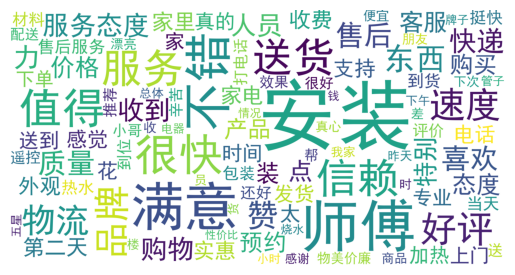

In [21]:
# 绘制词云
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# 正面情感词词云
freq_pos = posdata.groupby(by = ['word'])['word'].count()
freq_pos = freq_pos.sort_values(ascending = False)
backgroud_Image=plt.imread('data/p1.jpg')
wordcloud = WordCloud(font_path="simhei.ttf",
                      max_words=100,
                      background_color='white',
                      mask=backgroud_Image)
pos_wordcloud = wordcloud.fit_words(freq_pos)
plt.imshow(pos_wordcloud)
plt.axis('off') 
plt.show()

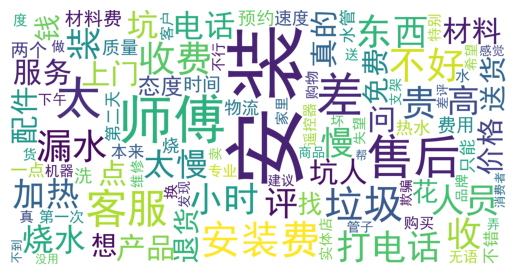

In [22]:
# 负面情感词词云
freq_neg = negdata.groupby(by = ['word'])['word'].count()
freq_neg = freq_neg.sort_values(ascending = False)
neg_wordcloud = wordcloud.fit_words(freq_neg)
plt.imshow(neg_wordcloud)
plt.axis('off') 
plt.show()

In [23]:
# 将结果写出,每条评论作为一行
posdata.to_csv("data/posdata.csv", index = False, encoding = 'utf-8')
negdata.to_csv("data/negdata.csv", index = False, encoding = 'utf-8')